---
<h1><B> Fraud Analytics (CS6890)  </h1></B></center>

---

<table>
<tr> 
<td><h3> Assignment : </td>
<td><h3> 1 </td>
</tr>
<tr> 
<td><h3> Title : </td>
<td><h3> Detection of circular trade </td>
</tr>
<tr> 
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr> 
<td><h5> Manan Darji </td>
<td><h5> CS22MTECH14004 </td>
</tr>
<tr> 
<td><h5> Dhwani Jakhaniya </td>
<td><h5> CS22MTECH14011 </td>
</tr>
<tr> 
<td><h5> Ankit Sharma </td>
<td><h5> CS22MTECH12003 </td>
</tr>
<tr> 
<td><h5> Vishesh Kothari </td>
<td><h5> CS22MTECH12004 </td>
</tr>
<tr> 
<td><h5> Jayanti Mudliar </td>
<td><h5> CS22MTECH14001 </td>
</tr>

<table>



</td>
</tr>
<table>


In [ ]:
import math
import pandas as pd
import numpy as np
import networkx as nx
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from node2vec import Node2Vec
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import warnings 

warnings.filterwarnings('ignore')

plt.style.use('seaborn')

In [ ]:
!pip3 install node2vec

In [ ]:
!pip install networkx==3.1

In [ ]:
# Difined global color
CLR = (199, 25, 24)
CLR = [x/255 for x in CLR]

In [ ]:
def ReadData(path):
  # Read data from csv
  df = pd.read_csv(path)
  Data = df.values
  print("Loded data of shape : ",Data.shape)
  return Data

In [ ]:
# Read Iron Dealers data
Data_Dealers = ReadData('Iron_dealers_data.csv')

# Defined Set of Unique Vetices and Edges
DistinctVertexSet = set()
Edges = set()

# Created Set of Unique Vetices and Edges
for Data in Data_Dealers:
    DistinctVertexSet.add(int(Data[0]))
    DistinctVertexSet.add(int(Data[1]))
    Edges.add((int(Data[0]),int(Data[1])))

# Created Total transetion dict as sum of all transection between 2 DistinctVertexSet
Amount = {}
for Data in Data_Dealers:
  if (int(Data[0]),int(Data[1])) in Amount:
    Amount[(int(Data[0]),int(Data[1]))] += Data[2]
  else:
    Amount[(int(Data[0]),int(Data[1]))] = Data[2]

# Converted set to list
DistinctVertexSet = list(DistinctVertexSet)
Edges = list(Edges)

# found total Vertices
N = len(DistinctVertexSet)

print("Total Delars : ",N)
print("Total Edges : ",len(Edges))


Loded data of shape :  (130535, 3)
Total Delars :  799
Total Edges :  5358


In [ ]:
# Here I have created a simple graph from the edges we found
GraphDircted = nx.DiGraph()
GraphDircted.add_edges_from(Edges)

In [ ]:
# Here I have found the cycles in the graph with length 2 and 3
cycles = list(nx.simple_cycles(GraphDircted , length_bound = 3))
len(cycles)

1907

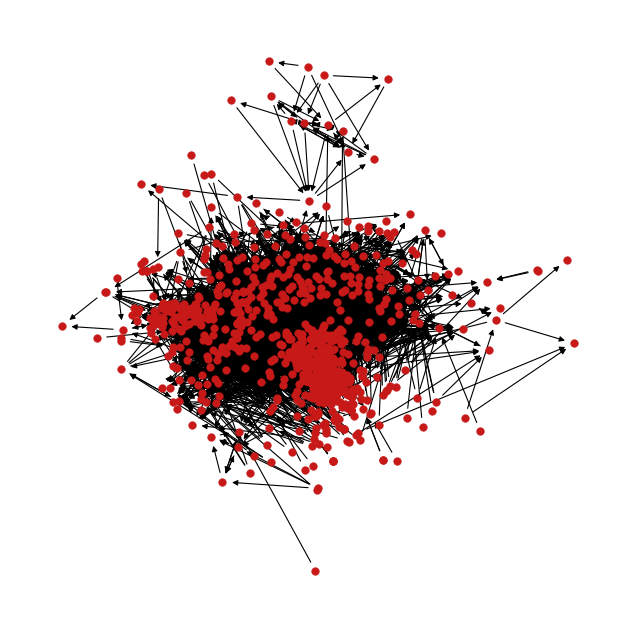

In [ ]:
def Plot_Graph(graph):
  """Just a simple function to plot the graph using NetworkX"""
  ccc = [CLR] * len(graph.nodes())
  plt.figure(num=None, figsize=(10, 10), dpi=80)
  plt.axis('off')
  fig = plt.figure(1)
  # pos = nx.spring_layout(graph)
  pos = nx.kamada_kawai_layout(graph)
  nx.draw_networkx_edges(graph,pos,alpha= 1)
  nx.draw_networkx_nodes(graph,pos,node_color=CLR,cmap='autumn_r',node_size=50)
  plt.show()
  del fig

Plot_Graph(GraphDircted)

We can see the Directed Graph that we generated here by combining multi edges into 1

In [ ]:
#  Initialization
flag = False
cnt = 0
N = len(DistinctVertexSet)
MAT = np.zeros((N,N))

# Iter over all edges
for v1,v2 in (Edges):
  InvolvedCycle = []

  # find indexes to use later in adjecency graph
  k1 = DistinctVertexSet.index(v1)
  k2 = DistinctVertexSet.index(v2)
  
  # iter over all cycles in graph
  for c in cycles:
    # find all cycles which have current edge
    if v1 in c and v2 in c:
      InvolvedCycle.append(c)

  # calculate the edge weight based on the cycles that it is part of
  for c in InvolvedCycle:
    # if part of 2 len cycle
    if len(c) == 2:
      # find summation over all edges of cycle
      cyclesum = 0
      cyclesum += Amount[c[0],c[1]]
      cyclesum += Amount[c[1],c[0]]

      # fractional weights of the edges [SoftMax]
      w1 = (Amount[c[0],c[1]] / cyclesum)
      w2 = (Amount[c[1],c[0]] / cyclesum)

      # FraudFactor as 1 - diffrence between 2
      d1 = 1 - abs(w1 - w2)
      FraudFactor = d1

      # Multiply by cycle summation to give more weitage to more trade value
      WeightByThisCycle = FraudFactor * cyclesum

      MAT[k1][k2] += WeightByThisCycle
      MAT[k2][k1] += WeightByThisCycle
    
    #  if part of 3 len cycle
    elif len(c) == 3:
      # find summation over all edges of cycle
      cyclesum = 0
      cyclesum += Amount[c[0],c[1]]
      cyclesum += Amount[c[1],c[2]]
      cyclesum += Amount[c[2],c[0]]

       # fractional weights of the edges [SoftMax]
      w1 = (Amount[c[0],c[1]] / cyclesum)
      w2 = (Amount[c[1],c[2]] / cyclesum)
      w3 = (Amount[c[2],c[0]] / cyclesum)

      # Diffrence as 1 - l1 norm
      d1 = 1 - abs(w1 - w2)
      d2 = 1 - abs(w2 - w3)
      d3 = 1 - abs(w3 - w1)

      # calc FraudFactor
      FraudFactor = (d1+d2+d3)/3

      # Multiply by cycle summation to give more weitage to more trade value
      WeightByThisCycle = FraudFactor * cyclesum

      MAT[k1][k2] += WeightByThisCycle
      MAT[k2][k1] += WeightByThisCycle
  
  # if len(InvolvedCycle) == 0:
  #   # If there is no weight then adding edge with minimum weight
  #   MAT[k1][k2] += -3.4028235e+38
  #   MAT[k2][k1] += -3.4028235e+38


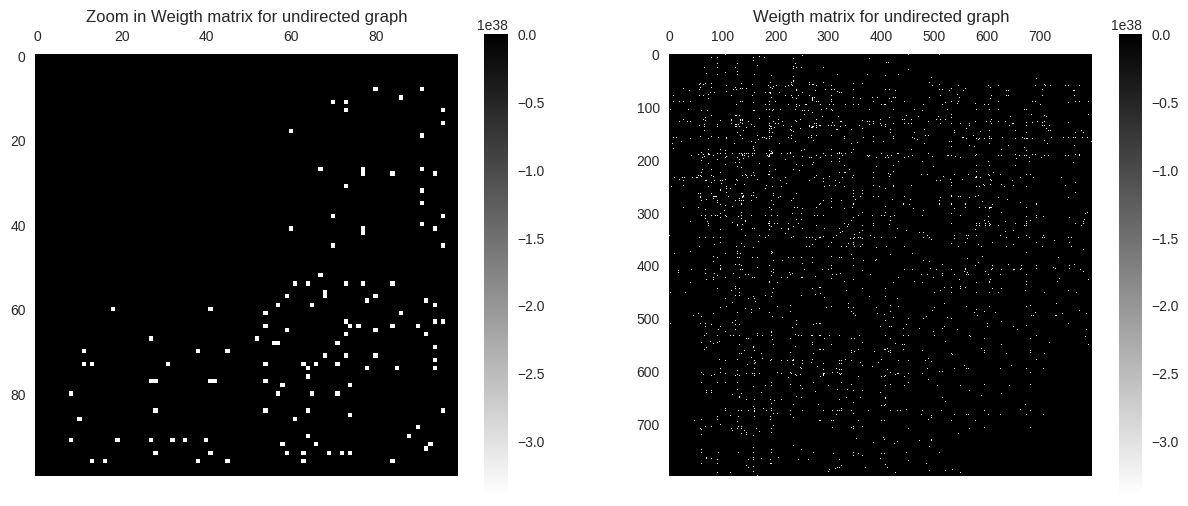

In [ ]:
cmap = cm.get_cmap('binary')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

cax1 = ax1.matshow(MAT[:100,:100], interpolation='nearest', cmap=cmap)
ax1.set_title("Zoom in Weigth matrix for undirected graph")
ax1.grid()

cax2 = ax2.matshow(MAT, interpolation='nearest', cmap=cmap)
ax2.set_title("Weigth matrix for undirected graph")
ax2.grid()
fig.colorbar(cax1)
fig.colorbar(cax2)

plt.show()

In [ ]:
len(Edges)

5358

In [ ]:
# create graph from adjacency list
GraphUndirected = nx.Graph()
GraphUndirected.add_nodes_from(list(GraphDircted.nodes))

for i in range(MAT.shape[0]):
    for j in range(i, MAT.shape[1]):
        if MAT[i][j] > 0:
          GraphUndirected.add_edge(DistinctVertexSet[i], DistinctVertexSet[j], weight=MAT[i][j])

print("Total Nodes in Undirected Graph:",len(GraphUndirected.nodes))
print("Total Edges in Undirected Graph:",len(GraphUndirected.edges))

# print graph info
Plot_Graph(GraphUndirected)


---

Total Nodes in Undirected Graph: 799

---

Total Edges in Undirected Graph: 1200

---

In [ ]:
# Applying Node 2 vec on our undirected graph
node2vec = Node2Vec(GraphUndirected, dimensions=64, walk_length=10, num_walks=500)

Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 500/500 [00:09<00:00, 54.83it/s]


In [ ]:
# Fitting the model
model = node2vec.fit(window=10, min_count=1)

In [ ]:
# extracting the embeddings
embeddings = {node: model.wv[str(node)] for node in GraphUndirected.nodes}
X = list(embeddings.values())

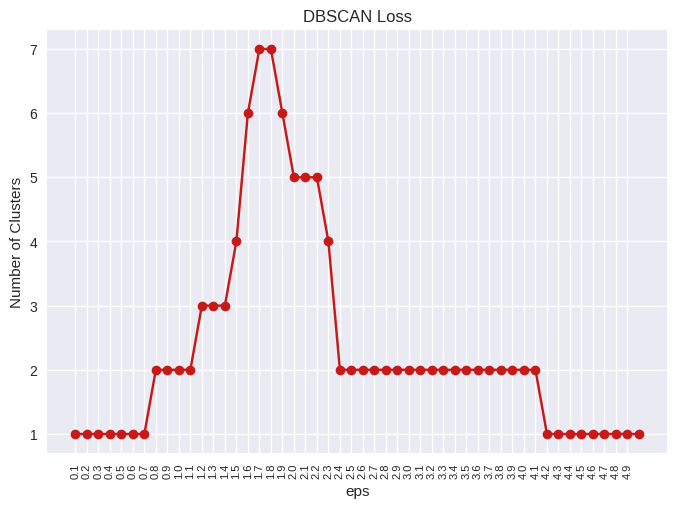

In [ ]:
# Hyper Perameter tuning for EPS value.
eps_range = np.linspace(0.1,5, 50)
num_clusters = []
besteps,bestclster = 0.1,0
# Testing for max cluster Eps
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan.fit(X)
    cls = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    num_clusters.append(cls)
    if bestclster < cls:
      bestclster = cls
      besteps = eps

# plot loss vs eps
plt.plot(eps_range, num_clusters,'o-',c=CLR)
plt.xticks(np.arange(min(eps_range), max(eps_range), 0.1))
plt.xticks(rotation = 90)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlabel('eps')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN Loss')
plt.show()

In [ ]:
print("Best Value for EPS based on hyper perameter tuning :",besteps )

Best Value for EPS based on hyper perameter tuning : 1.7000000000000002


In [ ]:
# Applying DBSCAN Clustering with best found eps value
clustering = DBSCAN(eps=besteps, min_samples=5).fit(X)
labels = clustering.labels_
X = np.asarray(X)

In [ ]:
# Finding the data to plot
Xplot = X[labels > -1]
labelsplot = labels[labels > -1]

Here I have Plotted the dataset in 5 dimentions( Using PCA )


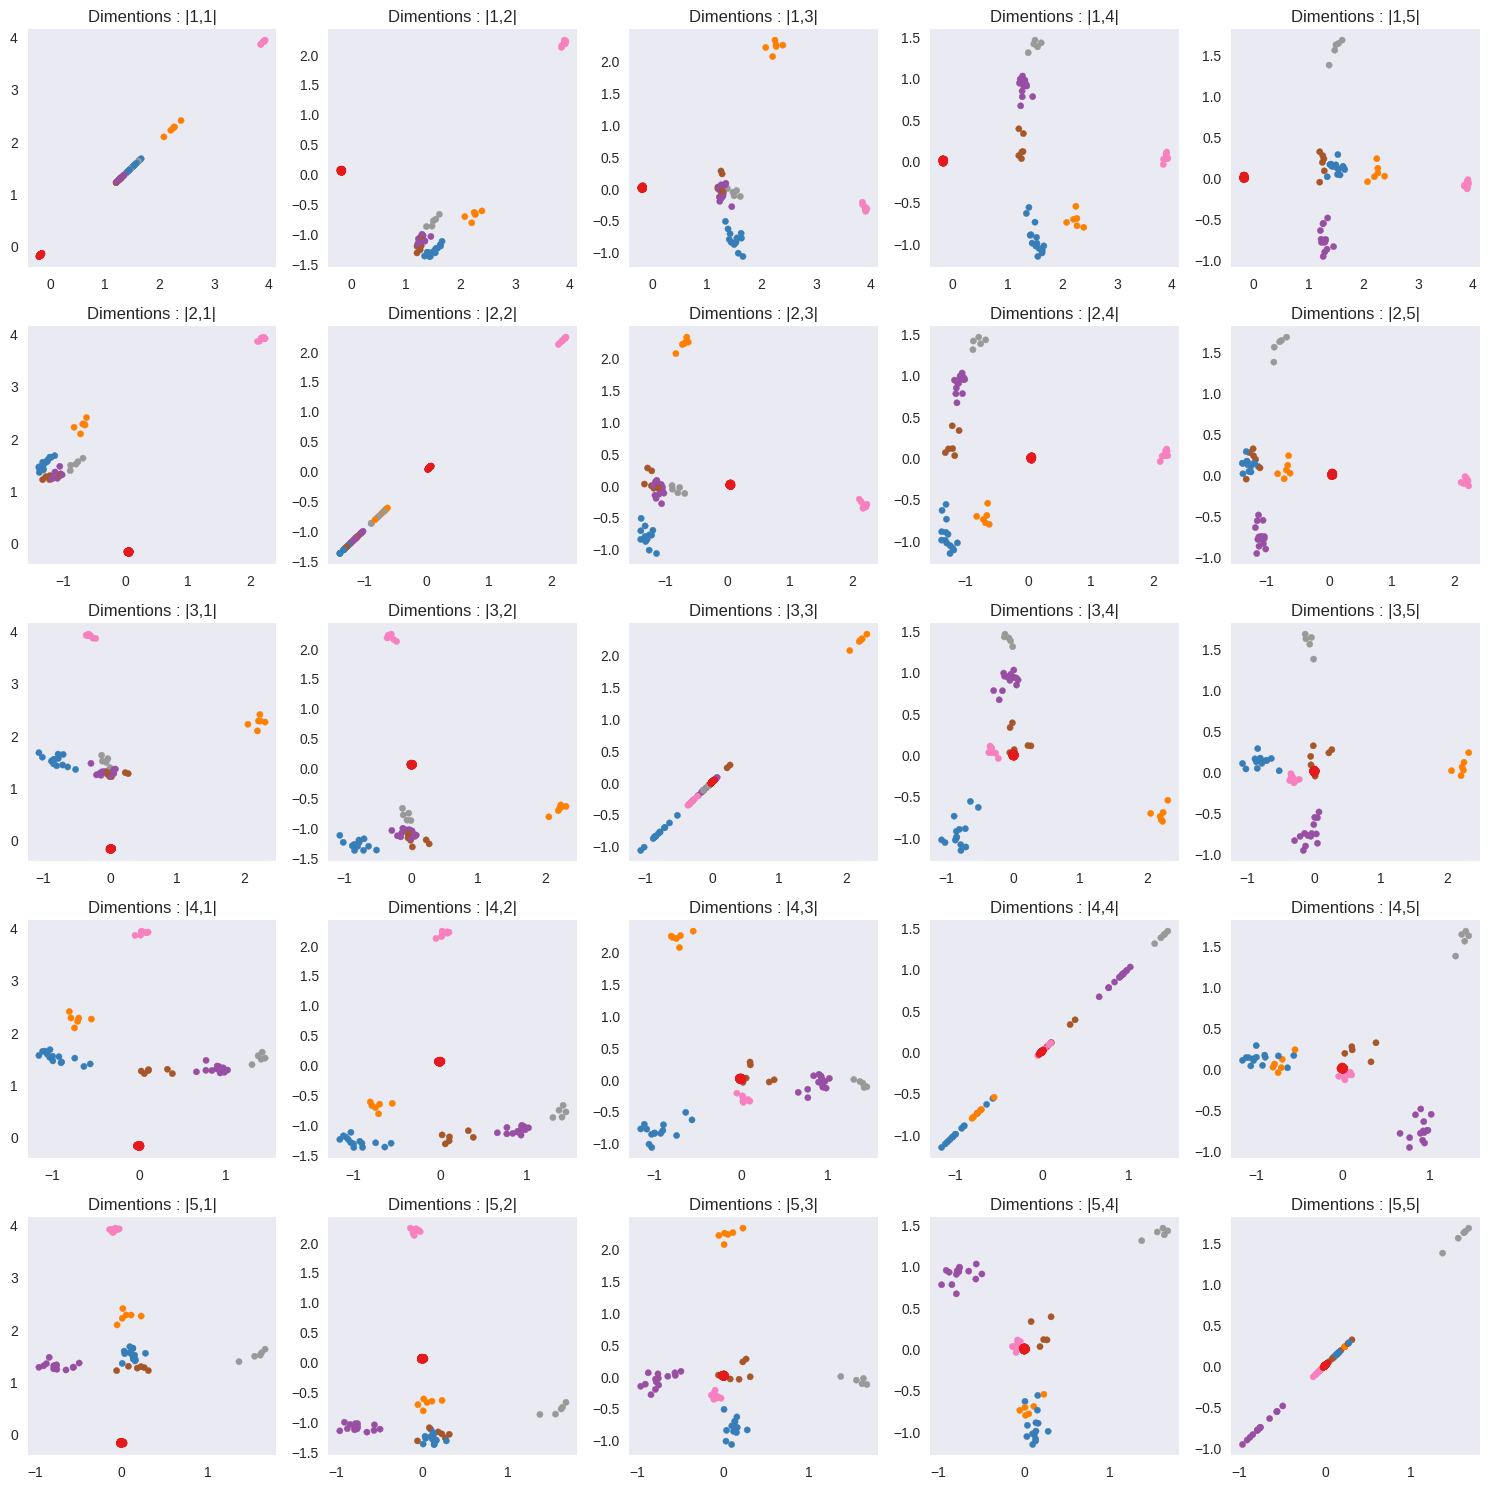

In [ ]:
# This is a simple function to visulize the multidimentional data
def ShowPCAplotDIM_NxN(X,Y,size=20,cmap = "Set1"):
  """
  This is a Simple Function to plot PCA Plot.
  """
  # Get the dimention of the data
  Dim = X.shape[1]
  plots = (Dim*Dim)
  # figure out number of rows and cols
  Cols = Rows = Dim
  S = 15//Cols
  p = 1
  # Init graph
  fig, ax = plt.subplots(Rows, Cols,figsize=(Cols * S,Rows * S))
  pi,pj = 0,0
  # Iter over all plots 
  for i in range(Dim):
    for j in range(Dim):
      # Plot Indivisual graph
      ax[pi,pj].set_title("Dimentions : |"+str(i+1)+","+str(j+1)+"|")
      ax[pi,pj].scatter(X[:,i], X[:,j], c=Y ,s=size,cmap=cmap)
      ax[pi,pj].grid()
      pj+=1
      if pj == Cols:
        pj = 0
        pi+= 1
  fig.tight_layout()
  plt.show()

print("Here I have Plotted the dataset in 5 dimentions( Using PCA )")
pca = PCA(n_components=5)
X5d =  pca.fit_transform(Xplot)
ShowPCAplotDIM_NxN(X5d,labelsplot)

In [ ]:
# distinct classes in clusters
Dset = list(set(labels))
Dset

[0, 1, 2, 3, 4, 5, 6, -1]

In [ ]:
# Finding all Undirected graph
nodes = list(GraphUndirected.nodes())

In [ ]:
# Finding the Dictionary with number of nodes in each cluster
dict1 = {} 
for l in labels:
  if l in dict1:
    dict1[l] += 1
  else:
    dict1[l] = 1
dict1

{0: 584, 2: 14, -1: 161, 4: 6, 1: 14, 3: 6, 6: 5, 5: 9}

In [ ]:
# cycles_ud = list(nx.simple_cycles(GraphUndirected , length_bound = 3))

65 38 14 22 27 12 

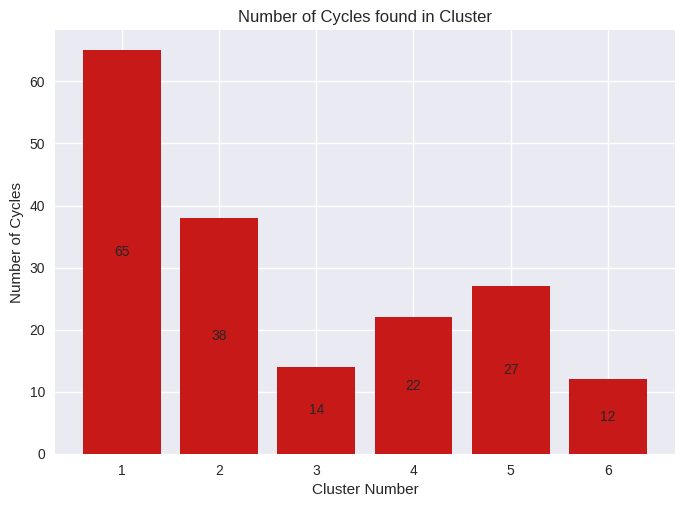

In [ ]:
# here we are checking from cluster how many nodes form a cycle in orignal graph
final = []
BarLbl = []
Dset = list(set(labels))
for j in Dset:
  if dict1[j] > 100:
    continue
  ind = []
  ids = []
  for i,val in enumerate(labels):
    if val == j:
      ind.append(i)
  ids = [nodes[i] for i in ind]
  InvolvedCycle = []
  # print(j,ind,ids)
  pairs2 = []
  for i in range(len(ids)):
    for j in range(i+1,len(ids)):
        pairs2.append((ids[i],ids[j]))

  pairs3 = []
  for i in range(len(ids)):
    for j in range(i+1,len(ids)):
      for k in range(j+1,len(ids)):
        pairs3.append((ids[i],ids[j],ids[k]))

  for c in cycles:
    if len(c)==2:
      for k1,k2 in pairs2:
        if k1 in c and k2 in c:
          InvolvedCycle.append(c)

    if len(c)==3:
      for k1,k2,k3 in pairs3:
        if k1 in c and k2 in c and k3 in c:
          InvolvedCycle.append(c)
  
  BarLbl.append(len(InvolvedCycle))
  print(len(InvolvedCycle) , end =' ')
  final.append(len(InvolvedCycle))

xx = np.linspace(1,len(final),len(final))

p = plt.bar(xx, final, color = CLR, label= BarLbl)
plt.bar_label(p, label_type='center')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Cycles')
plt.title('Number of Cycles found in Cluster')
plt.show()